In [1]:
from example_utils import *
!rm -rf train_model

# Asynchronous, Offline Optimization

We first set up a toy problem: 1D linear regression 

In [2]:
import numpy as np
from digital_experiments import experiment

np.random.seed(2)
X = np.random.rand(200) * 10
y = 2 * X + 3 + np.random.randn(200)

@experiment(verbose=False)
def train_model(m, c):
    model = lambda x: m * x + c

    yhat = model(X)
    absolute_errors = np.abs(yhat - y)

    return {
        "mae": absolute_errors.mean(), 
        "rmse": (absolute_errors**2).mean() ** 0.5,
    }

What does our data look like?

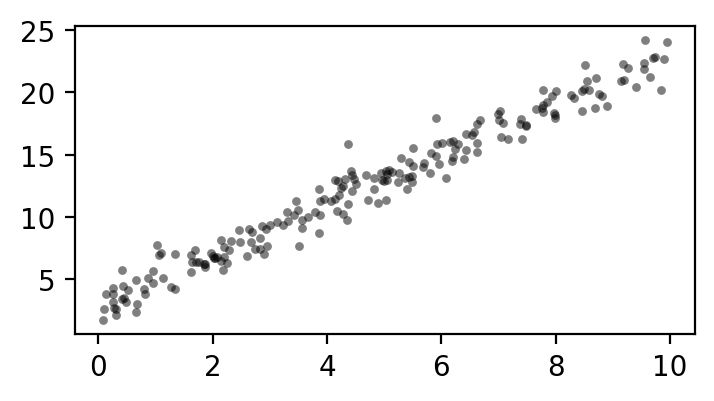

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [5, 5]

plt.figure(figsize=(4, 2))
plt.scatter(X, y, linewidths=0, s=10, c='k', alpha=0.5);

# Manual Runs

In [4]:
train_model(m=0, c=0)
train_model(m=5, c=5)
train_model(m=0, c=5)

{'mae': 7.6705099597961715, 'rmse': 9.2525485924273}

# Automated Optimization

We can automatically optimize the hyperparameters of our model using successive calls to `digital_experiments.optimize_step_for`.

Under the hood, this reads all previous calls to our function, and generates either 
- new random points to sample 
- new points using Bayesian Optmization to minimize the functions value

Importantly, `optimize_step` is stateless: we could run this in successive python sessions.

In [5]:
from digital_experiments import optimize_step_for, Real

space = {
    "m": Real(0, 5),
    "c": Real(0, 5),
}

random_points = 10
opt_points = 6

for i in range(random_points + opt_points):
    optimize_step_for(
        train_model, 
        loss_fn=lambda results: results['rmse'], 
        n_random_points=random_points, 
        space=space
    )

ValueError: too many values to unpack (expected 2)

# How did we do?

What is the best choice for m and c that we have found? Remember the true values are 2 and 3 respectively.

In [ ]:
from digital_experiments import all_experiments_matching

df, experiments = all_experiments_matching("train_model")
dict(df.sort_values("rmse").iloc[0])

{'experiment_number': 14.0,
 'm': 1.9326479171082422,
 'c': 3.39780702895783,
 'mae': 0.8399754929617737,
 'rmse': 1.0580830901521383}

We can see how our accuracy improved with time:

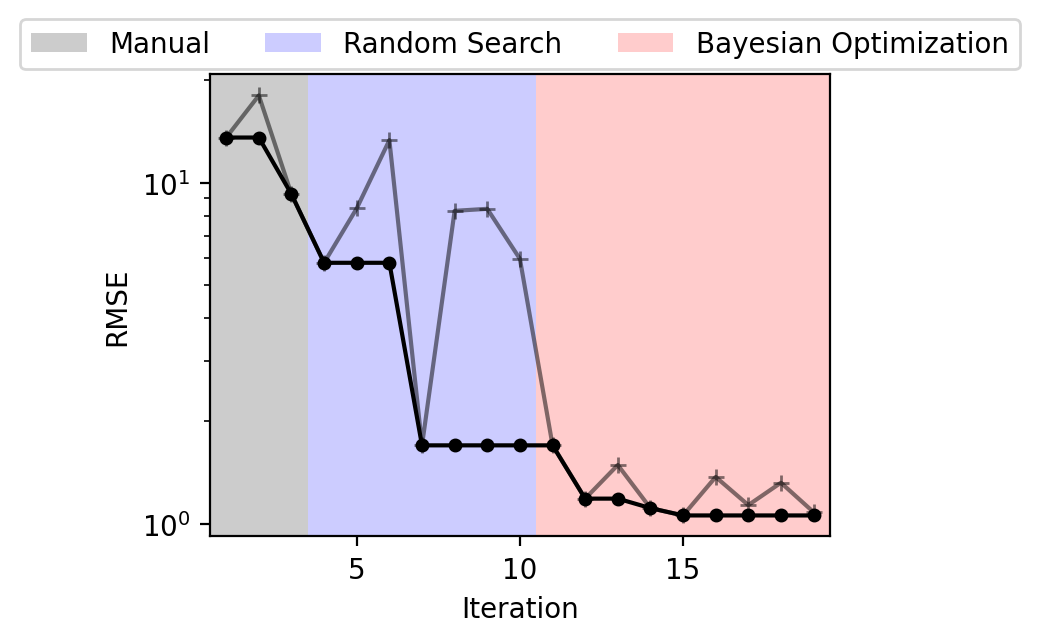

In [ ]:
from digital_experiments.plots import track_minimization
    

plt.figure(figsize=(4, 3))
track_minimization("train_model", lambda results: results["rmse"])
plt.ylabel("RMSE")
plt.yscale("log");

... and also where in search space the guesses happened:


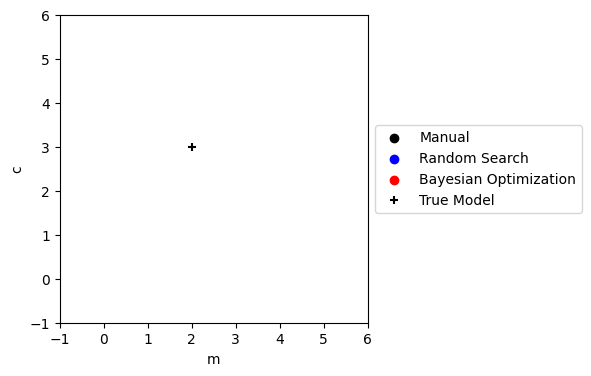

<Figure size 500x500 with 0 Axes>

In [ ]:
from digital_experiments.plots import track_trials  

def tidy_up(*args):
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter([2], [3], c='k', marker="+", label="True Model")
    plt.gca().set_aspect("equal")

track_trials("m", "c", "train_model", tidy_up, fps=2)